In [25]:
%pip install matplotlib seaborn plotly streamlit
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
%pip install jaxtyping transformer_lens
%pip install ..

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Processing /home/andrew/Documents/Code/MechIR
  Preparing metadata (setup.py) ... done
  Created wheel for mechir: filename=mechir-0.0.1-py3-none-any.whl size=75737 sha256=0f91d695f569edd4729980c5522700098fac1dada5a57b639cc3ff8357b22503
  Stored in directory: /tmp/pip-ephem-wheel-cache-9wgomev6/wheels/16/4d/fd/e2f041bb0629a1af518d10cab4601f84986b0213a8a30041cf
Successfully built mechir
  Attempting uninstall: mechir
    Found existing installation: mechir 0.0.1
    Uninstalling mechir-0.0.1:
      Successfully uninstalled mechir-0.0.1
Note: you may need to restart the kernel to use updated packages.


In [26]:
from mechir.plotting import plot_components
import os
import numpy as np

In [27]:
DIR = r'../data/patching/'

In [28]:
out = {}
for file in os.listdir(DIR):
    out[file] = np.load(DIR + file)

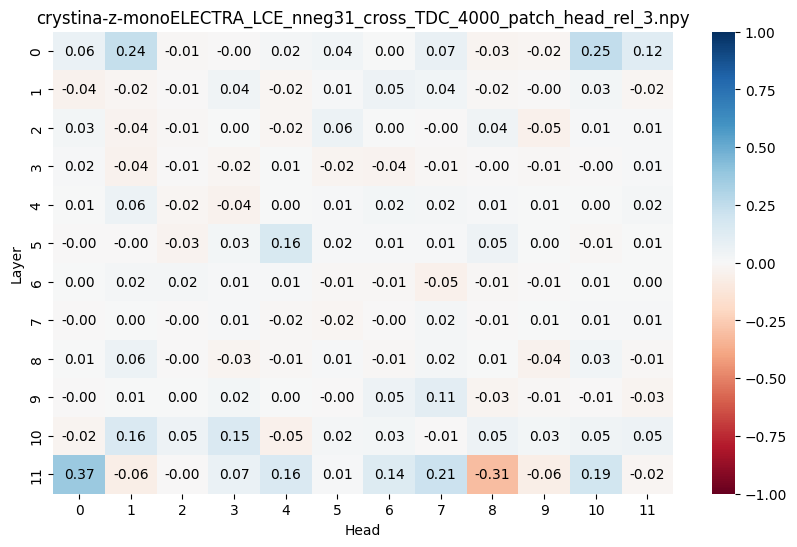

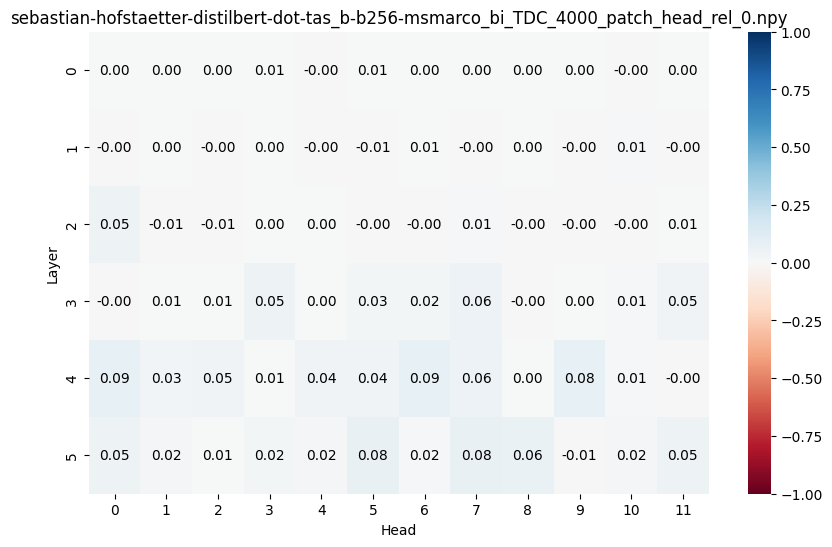

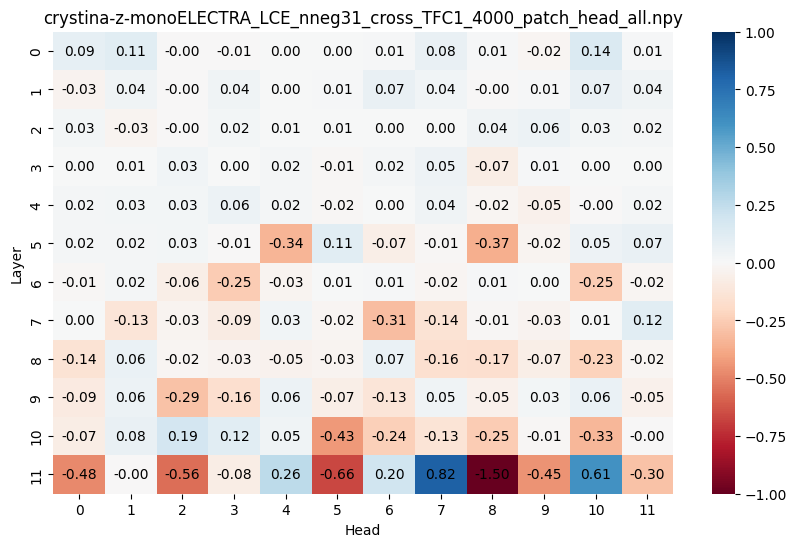

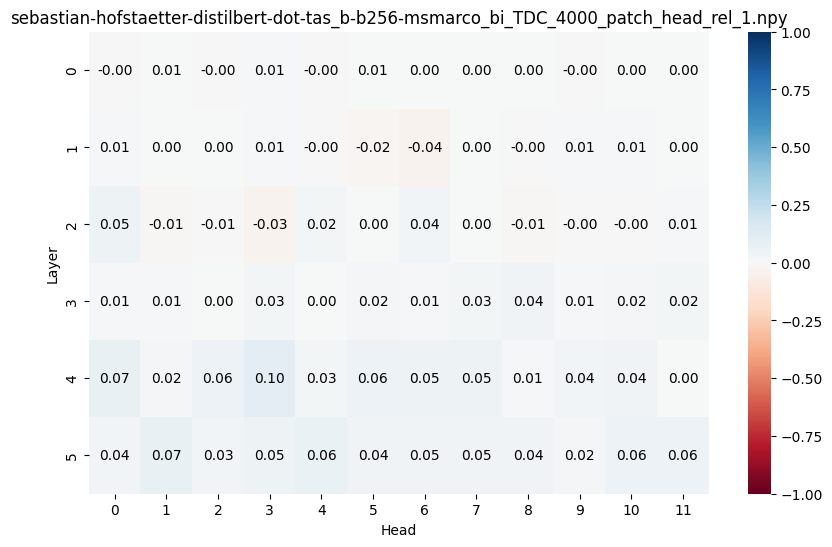

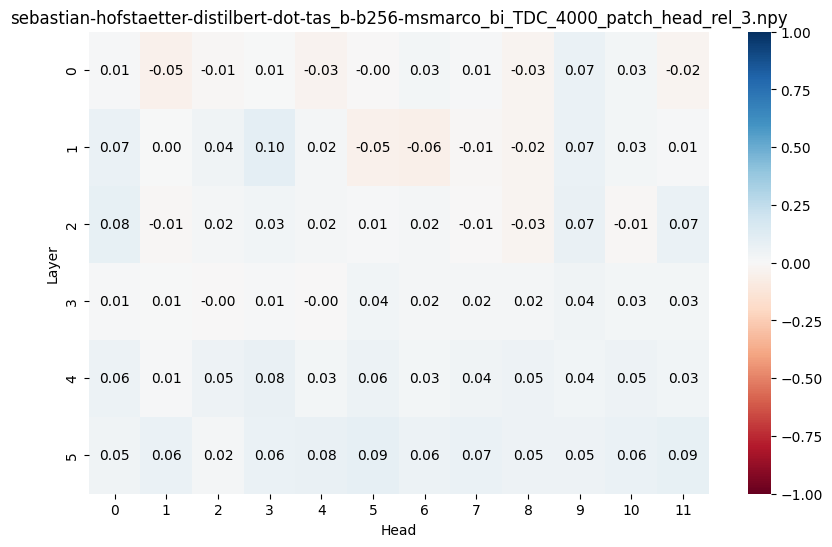

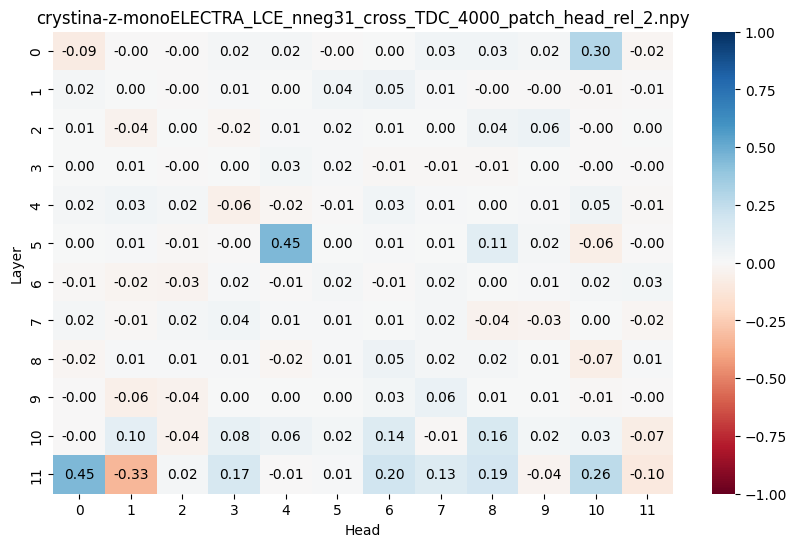

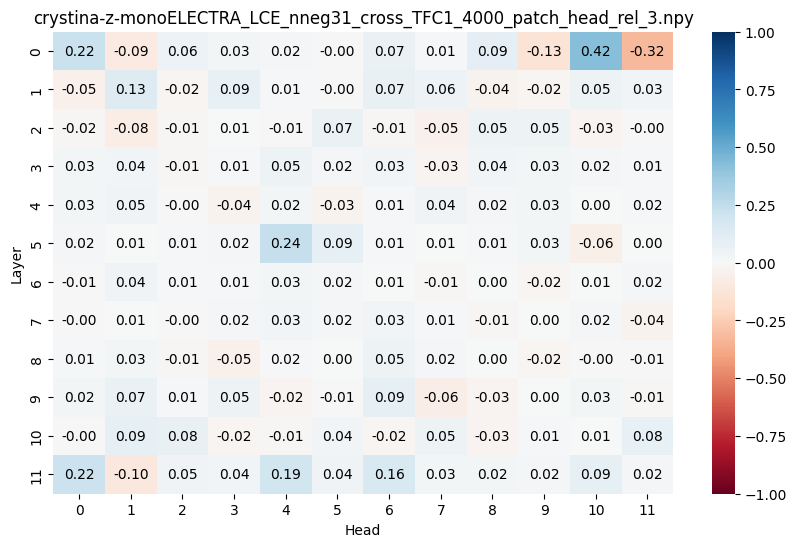

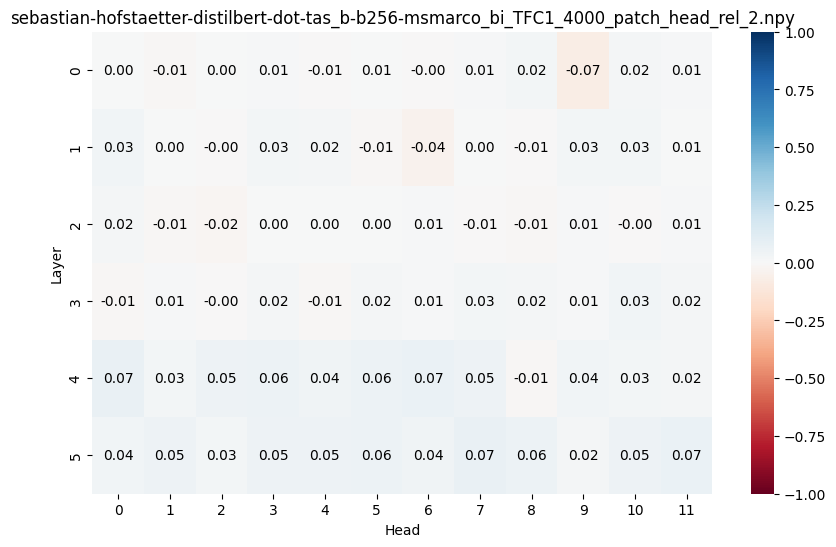

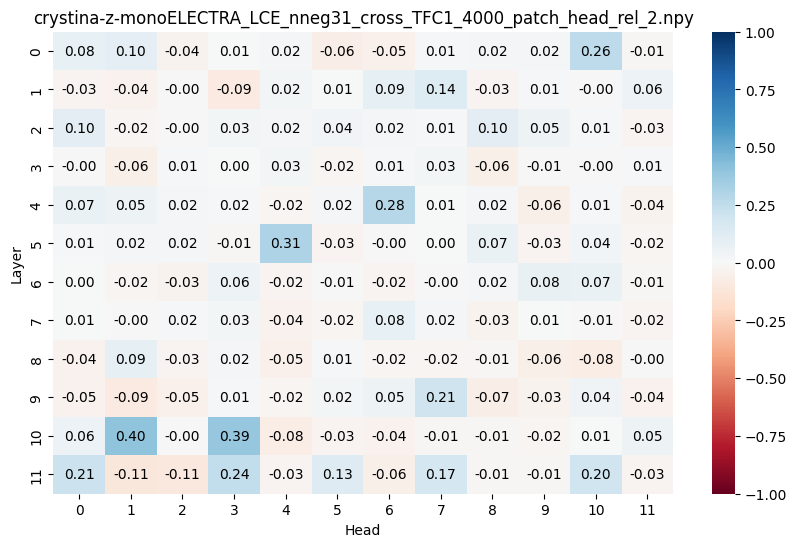

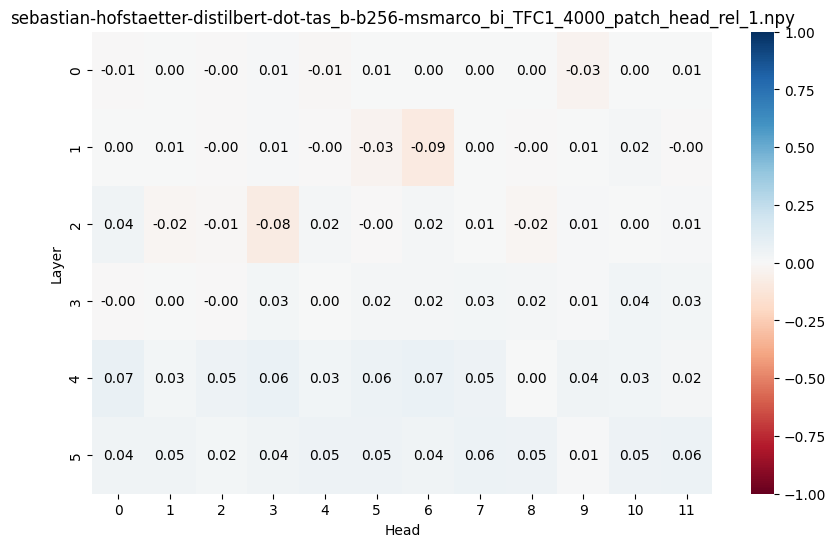

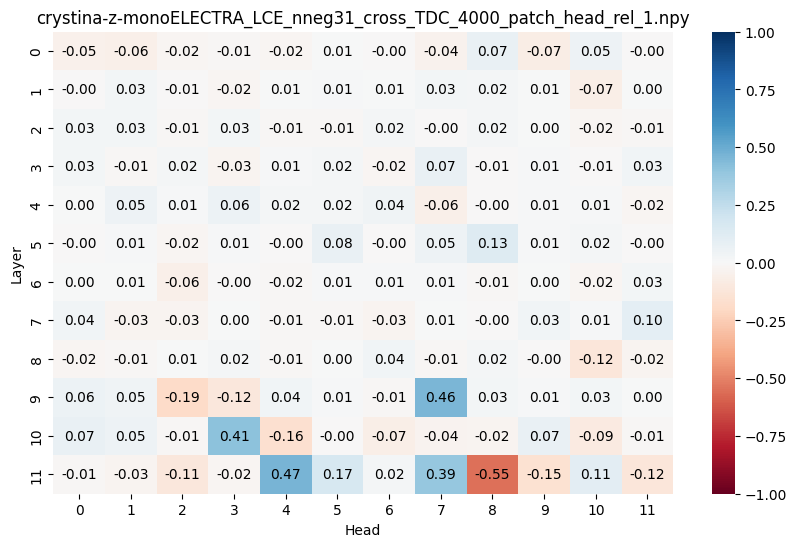

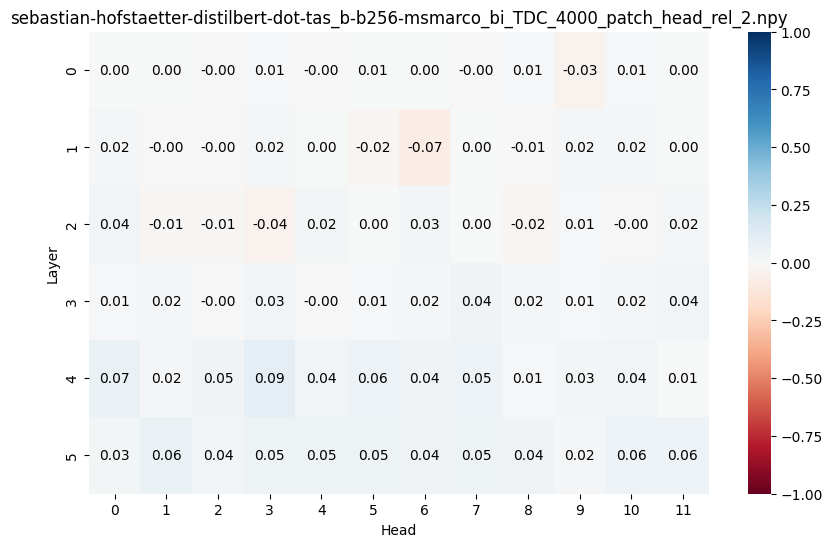

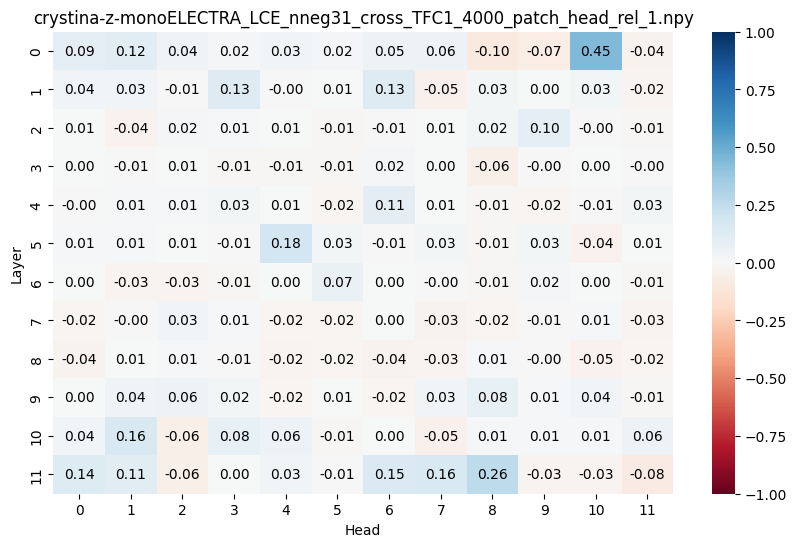

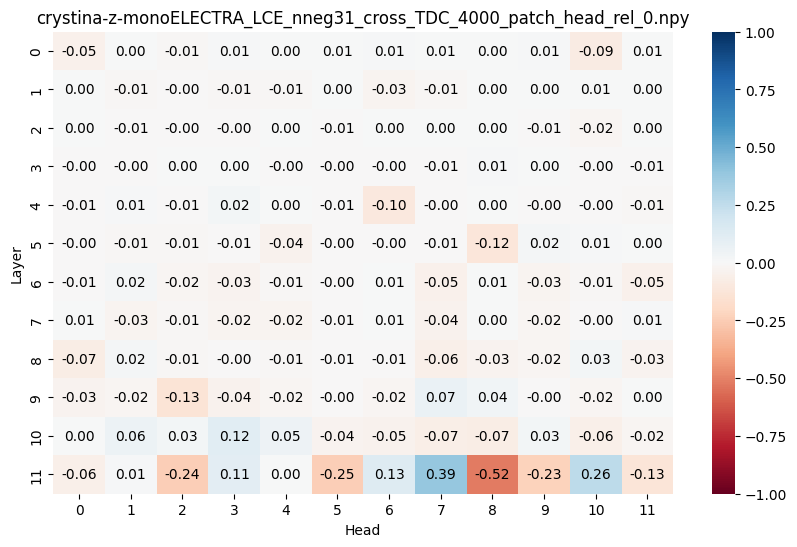

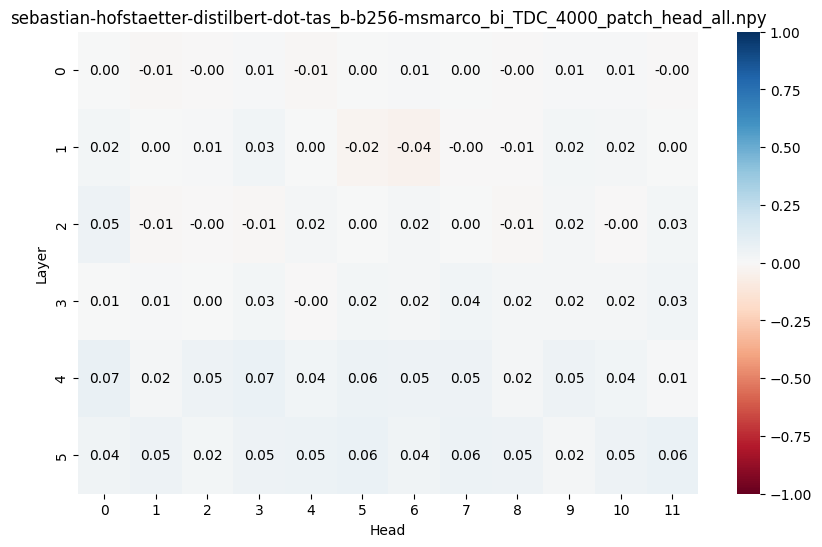

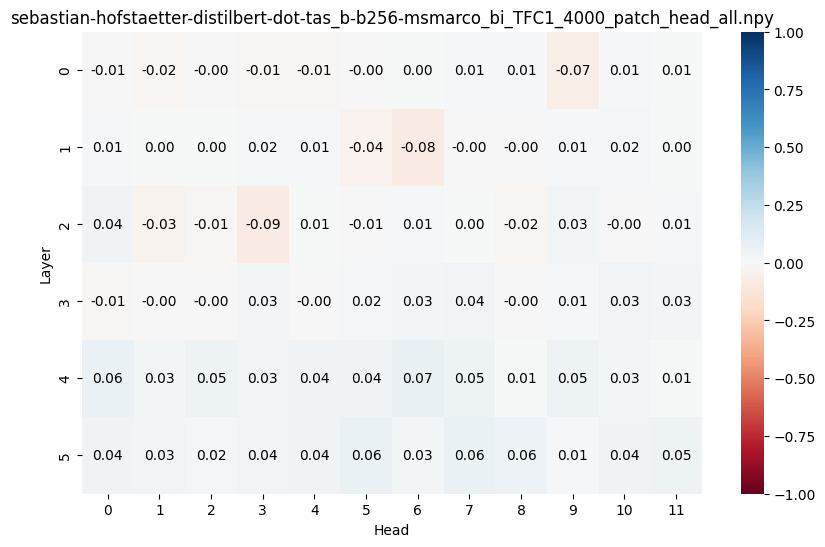

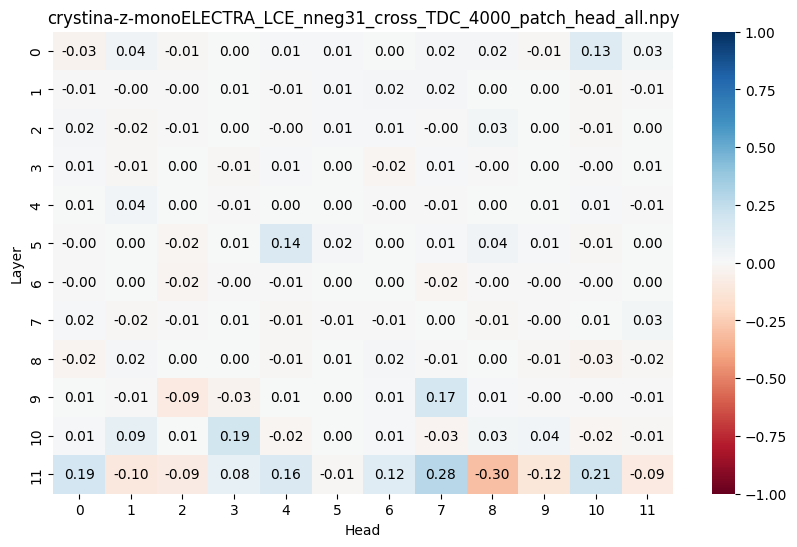

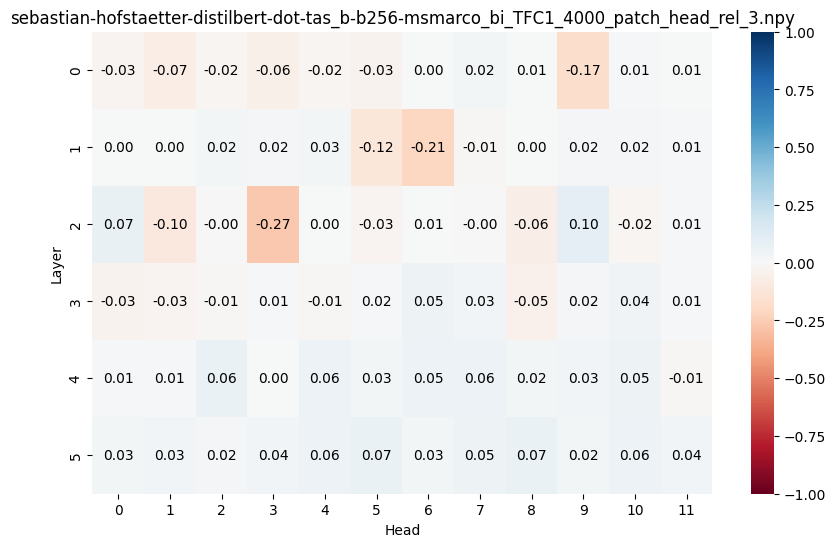

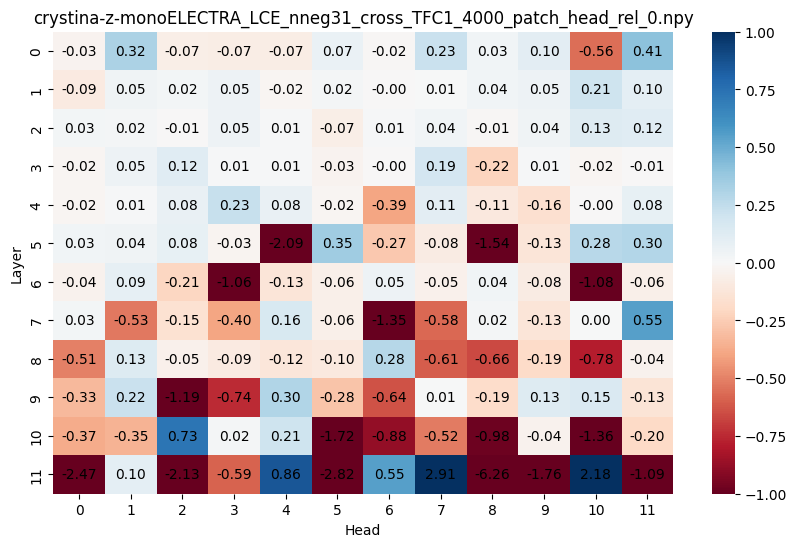

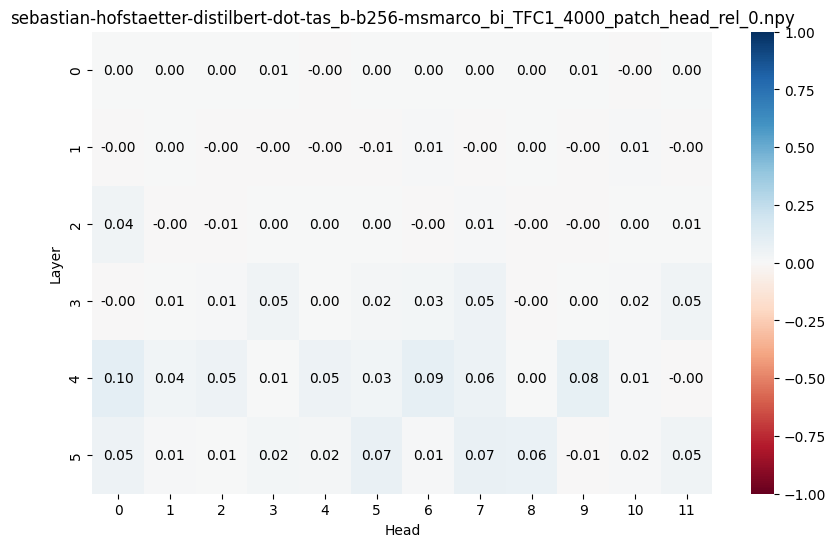

In [29]:
for file in out:
    plot_components(out[file], title=file, save_path=None, include_mlp=False)